In [20]:
import numpy as np
import seaborn as sns
import pandas as pd

In [21]:
sns.set_theme(style="whitegrid")

In [22]:
df = pd.read_csv("results.csv", index_col=0)
df

,Block Dim,Size,Steps,Time
4,256,100,100,458.301
4,256,1000,100,474.464
4,256,2000,100,505.127
4,256,100,1000,4546.784
4,256,1000,1000,4706.944
...,...,...,...,...
256,4,1000,10000,48286.688
256,4,2000,10000,54371.230
256,4,100,100000,448256.438
256,4,1000,100000,481991.188


In [23]:
# Fix columns
df.index

Index([  4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   8,   8,
         8,   8,   8,   8,   8,   8,   8,   8,   8,   8,  16,  16,  16,  16,
        16,  16,  16,  16,  16,  16,  16,  16,  32,  32,  32,  32,  32,  32,
        32,  32,  32,  32,  32,  32,  64,  64,  64,  64,  64,  64,  64,  64,
        64,  64,  64,  64, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
       128, 128, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256],
      dtype='int64')

In [24]:
df = df.reset_index().rename(columns={'index': 'Block X', "Block Dim": "Block Y"})
print(df.shape)
df.head(10)

(84, 5)


,Block X,Block Y,Size,Steps,Time
0,4,256,100,100,458.301
1,4,256,1000,100,474.464
2,4,256,2000,100,505.127
3,4,256,100,1000,4546.784
4,4,256,1000,1000,4706.944
5,4,256,2000,1000,5014.381
6,4,256,100,10000,45698.949
7,4,256,1000,10000,47047.078
8,4,256,2000,10000,49992.352
9,4,256,100,100000,445655.594


In [25]:
serial_df = pd.read_csv("serial.csv").drop(columns=["program", "threads"])
serial_df

,steps,size,time(s)
0,100,100,0.01
1,1000,100,0.11
2,10000,100,1.02
3,100000,100,10.18
4,100,1000,1.34
5,1000,1000,12.37
6,10000,1000,109.60
7,100000,1000,1072.98
8,100,2000,5.33
9,1000,2000,48.66


In [26]:
df["Time"] = df["Time"].apply(lambda x: x / 1000)

In [27]:
times_df = df.groupby(["Size", "Steps"])["Time"].mean()
times_df

Size  Steps 
100   100         0.450391
      1000        4.561605
      10000      44.394348
      100000    445.999201
1000  100         0.481695
      1000        4.780335
      10000      47.734473
      100000    476.455040
2000  100         0.532055
      1000        5.273015
      10000      52.656391
      100000    526.887625
Name: Time, dtype: float64

In [28]:
_df = times_df.copy()

_df = _df.reset_index()
_df = pd.merge(_df, serial_df.rename(columns={'size': 'Size', 'steps': 'Steps', 'time(s)': 'Serial Time'}), on=['Size', 'Steps'], how='left')
_df = _df.set_index(['Size', 'Steps'])

with open("csv/times-df.csv", "w") as f:
	_df.to_csv(f, float_format="%.3f")

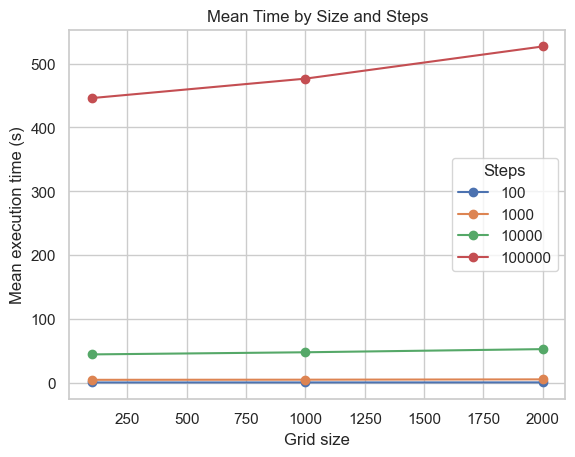

In [29]:
import matplotlib.pyplot as plt

times_df.unstack().plot(marker='o')
plt.xlabel("Grid size")
plt.ylabel("Mean execution time (s)")
plt.title("Mean Time by Size and Steps")
plt.show()

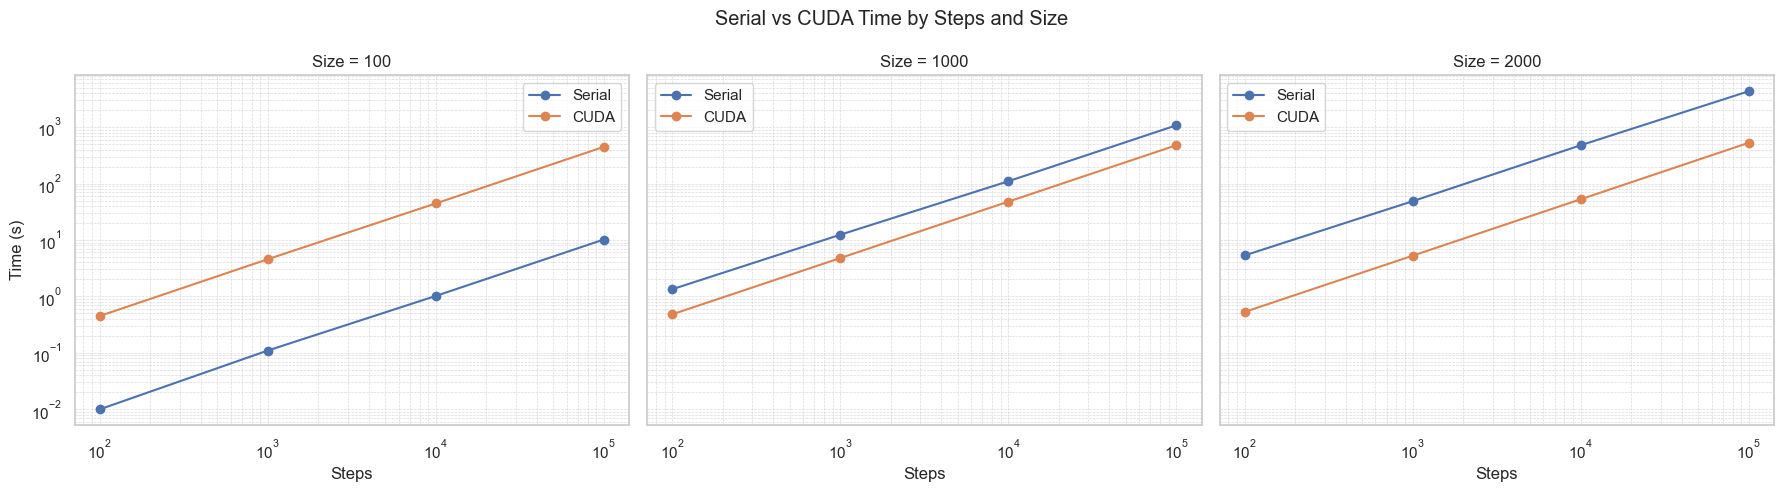

In [30]:
# Prepare data for plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

sizes = serial_df['size'].unique()
for i, size in enumerate(sizes):
	# Serial data
	serial_subset = serial_df[serial_df['size'] == size]
	# CUDA data
	cuda_subset = times_df.loc[size]
	axes[i].plot(serial_subset['steps'], serial_subset['time(s)'], marker='o', label='Serial')
	axes[i].plot(cuda_subset.index, cuda_subset.values, marker='o', label='CUDA')
	axes[i].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
	axes[i].set_xscale('log')
	axes[i].set_yscale('log')
	axes[i].set_title(f'Size = {size}')
	axes[i].set_xlabel('Steps')
	if i == 0:
		axes[i].set_ylabel('Time (s)')
	axes[i].legend()

fig.suptitle('Serial vs CUDA Time by Steps and Size')
plt.tight_layout()
plt.show()

In [31]:
# Fix KeyError: 'Size' by renaming columns to match
serial_df = serial_df.rename(columns={'size': 'Size', 'steps': 'Steps', 'time(s)': 'Time'})
# Calculate speedup = Serial Time / CUDA Time for each Size and Steps
speedup_df = pd.merge(
	serial_df,
	times_df,
	on=["Size", "Steps"],
	suffixes=('_serial', '_cuda')
)
speedup_df["Speedup"] = speedup_df["Time_serial"] / speedup_df["Time_cuda"]
speedup_df = speedup_df[["Size", "Steps", "Speedup"]]

In [32]:
speedup_df

,Size,Steps,Speedup
0,100,100,0.022203
1,100,1000,0.024114
2,100,10000,0.022976
3,100,100000,0.022825
4,1000,100,2.781841
5,1000,1000,2.587685
6,1000,10000,2.296035
7,1000,100000,2.252007
8,2000,100,10.017767
9,2000,1000,9.228117


<Axes: xlabel='Size', ylabel='Mean Speedup'>

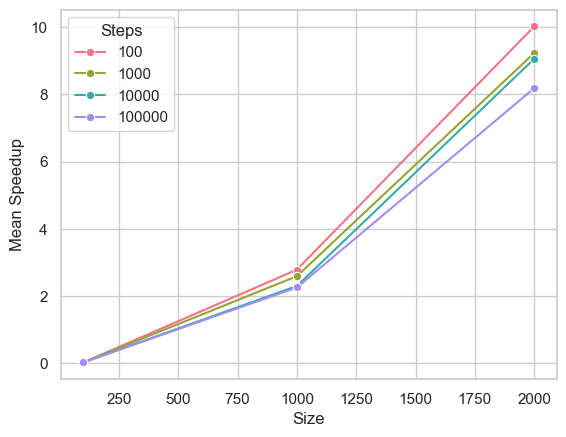

In [33]:
# Compute mean speedup for each Size and Steps
mean_speedup = speedup_df.groupby(['Size', 'Steps'])['Speedup'].mean().unstack()

mean_speedup_reset = mean_speedup.reset_index().melt(id_vars="Size", var_name="Steps", value_name="Mean Speedup")
palette = sns.color_palette("husl", n_colors=mean_speedup_reset["Steps"].nunique())
sns.lineplot(
	data=mean_speedup_reset,
	x="Size",
	y="Mean Speedup",
	hue="Steps",
	marker="o",
	palette=palette
)

In [34]:
speedup_df.to_csv("csv/speedup.csv", float_format="%.3f", index=False)

In [35]:
# Calculate relative efficiency for two samples: largest (size==2000, max steps) and smallest (size==100, min steps)
largest_sample = speedup_df[(speedup_df["Size"] == 2000) & (speedup_df["Steps"] == 100000)]
smallest_sample = speedup_df[(speedup_df["Size"] == 100) & (speedup_df["Steps"] == 100)]

efficiency = pd.DataFrame({
	"Sample": ["Smallest", "Largest"],
	"Size": [100, 2000],
	"Steps": [smallest_sample["Steps"].values[0], largest_sample["Steps"].values[0]],
	"Speedup": [smallest_sample["Speedup"].values[0], largest_sample["Speedup"].values[0]],
	"Relative Efficiency": [largest_sample["Speedup"].values[0] / smallest_sample["Speedup"].values[0], None]
})
efficiency

,Sample,Size,Steps,Speedup,Relative Efficiency
0,Smallest,100,100,0.022203,368.460065
1,Largest,2000,100000,8.180891,NaN


In [36]:
efficiency.to_csv("csv/relative-efficiency.csv", float_format="%.3f", index=False)

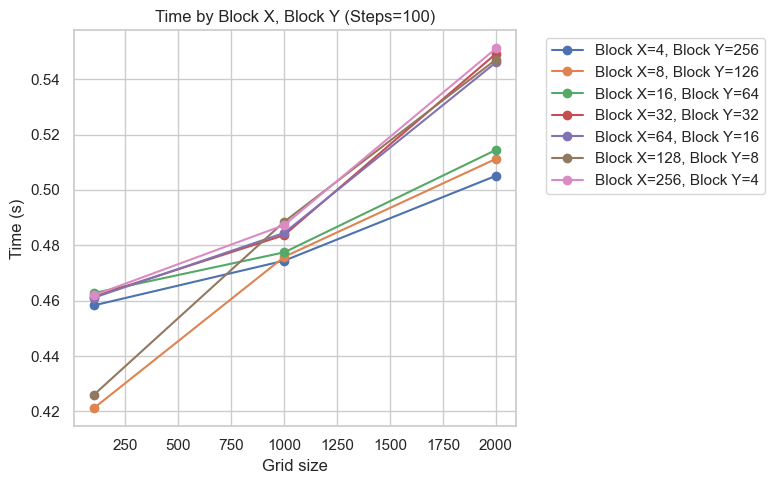

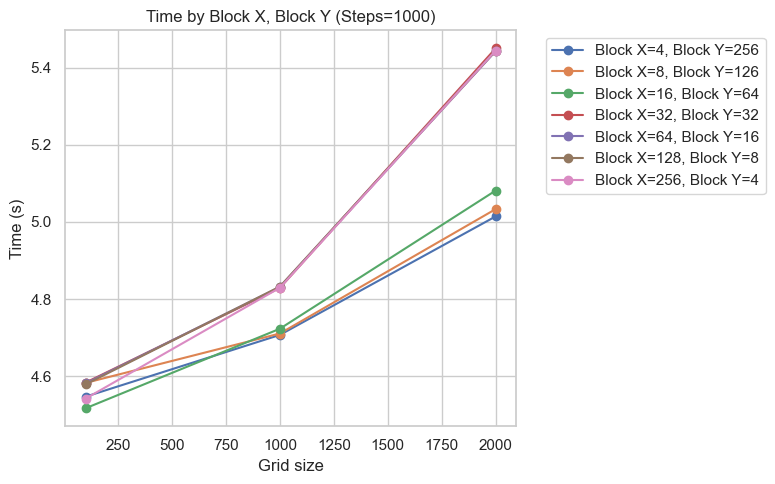

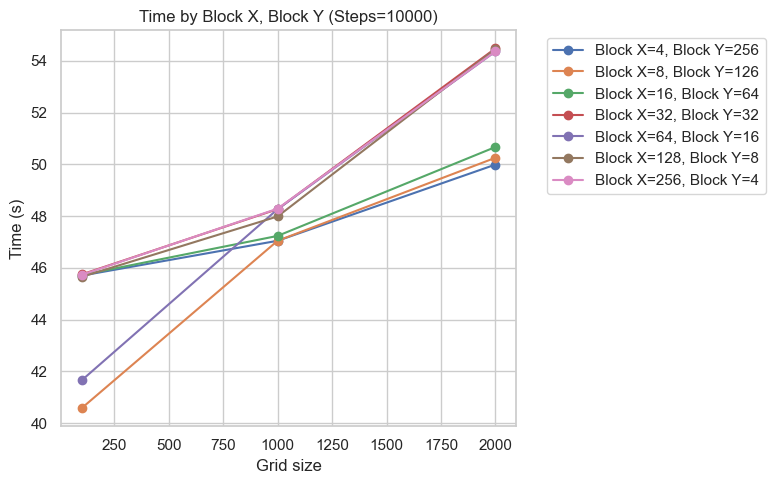

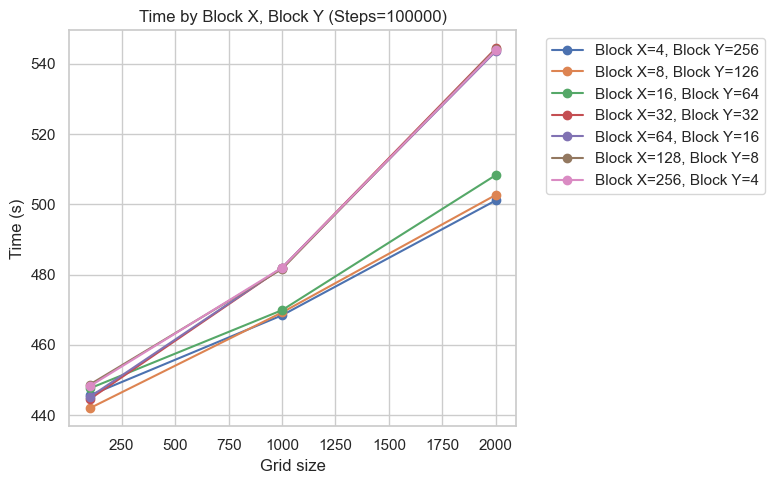

In [46]:
grouped_by_block = df.groupby(['Block X', 'Block Y', 'Steps'])

# Create separate plots for each unique Steps value
unique_steps = df['Steps'].unique()
for step in unique_steps:
	plt.figure(figsize=(8, 5))
	for (block_x, block_y, steps), group in grouped_by_block:
		if steps == step:
			plt.plot(group["Size"], group["Time"], marker='o', label=f'Block X={block_x}, Block Y={block_y}')
	plt.xlabel("Grid size")
	plt.ylabel("Time (s)")
	plt.title(f"Time by Block X, Block Y (Steps={step})")
	plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
	plt.tight_layout()
	plt.show()